# Pivotal Tuning Editing: Towards Disentangled Wrinkle Editing with GANs

Generative Adversarial Networks (GANs) enable image editing by manipulating image features. However, these manipulations still lack disentanglement. For example, when a specific wrinkle is edited, other age-related features or facial expressions are often changed as well. This paper proposes a new method for disentangled editing. The presented approach is based on two pivot images that allow learning an editing direction for an input image. These pivots are based on a real image (the input) and a synthetic modification of the real image along the desired editing direction. Although our primary focus is on wrinkle editing applications, our method can be extended to other editing tasks, such as hair color or lipstick editing. Qualitative and quantitative results show that our Pivotal Tuning Editing (PTE) provides a higher level of disentanglement and a more realistic editing than state-of-the-art methods.

# Set up

If you are on Windows please install C++ with Microsoft Visual Studio to be able to run StyleGAN plugins. Once install you may need to change the path of the VsDevCmd.bat

In [1]:
# Reload all modules
%load_ext autoreload
%autoreload 2

# Set up msvc to load the generator
import os
import platform

if platform.system() == "Windows":
    assert os.path.exists(r"C:\Program Files\Microsoft Visual Studio\2022\Community\Common7\Tools\VsDevCmd.bat"), "The path to VsDevCmd is not valid, please modify it"
    # Warning: The path may not be exact for you, please check it!
    os.system(r'"C:\Program Files\Microsoft Visual Studio\2022\Community\Common7\Tools\VsDevCmd.bat" -arch=x64 -host_arch=x64')
    
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import warnings
warnings.filterwarnings("ignore")

In [2]:
import json
import torch
import numpy as np
import cv2

from generator.utils import gen_w_space, keep_w, keep_w_image, load_stylegan2_generator, stylegan_invert_img_convert
from invertor.pte import PivotalTuningEdition
from image.edit import transfer_color, wrinkle_remover

In [3]:
# Config file of the generator
config_path = "./generator/stylegan2/config_1024.json"

with open(config_path, "r+") as config:
    generator = load_stylegan2_generator(json.load(config))

# Custom argument of the generator
generator_kwargs = {
    "input_is_latent": True,
    "return_latents": False,
    "input_is_style": False,
    "noise_mode": "const",
}

Loading StyleGAN2 from checkpoint: C:\Users\Neil\OneDrive - Professional\Documents\Python scripts\These\TheseUtils\generator\pretrained_models\stylegan2\stylegan2_1024.pt


In [4]:
space_modifier = lambda x: x.repeat(1, 18, 1)
space_kept = keep_w
space_kept_image = keep_w_image

initial_latent_modifier = lambda x : x[..., 0, :].reshape(1, 1, -1).to("cuda").requires_grad_(True)
input_generator = [
    lambda: gen_w_space(
        generator, z_dim=512
    ).unsqueeze(0),
    lambda: torch.zeros([1, 0], device="cuda"),
]
latent_from_flat = lambda latent: latent[np.newaxis, np.newaxis, ...]
loaded_latents = torch.stack([
    input_generator[0]() for x in range(1000)
]).squeeze(1)
initial_latent = initial_latent_modifier(loaded_latents.mean(axis=0))

Setting up PyTorch plugin "bias_act_plugin"... Done.


# Generating image with StyleGAN

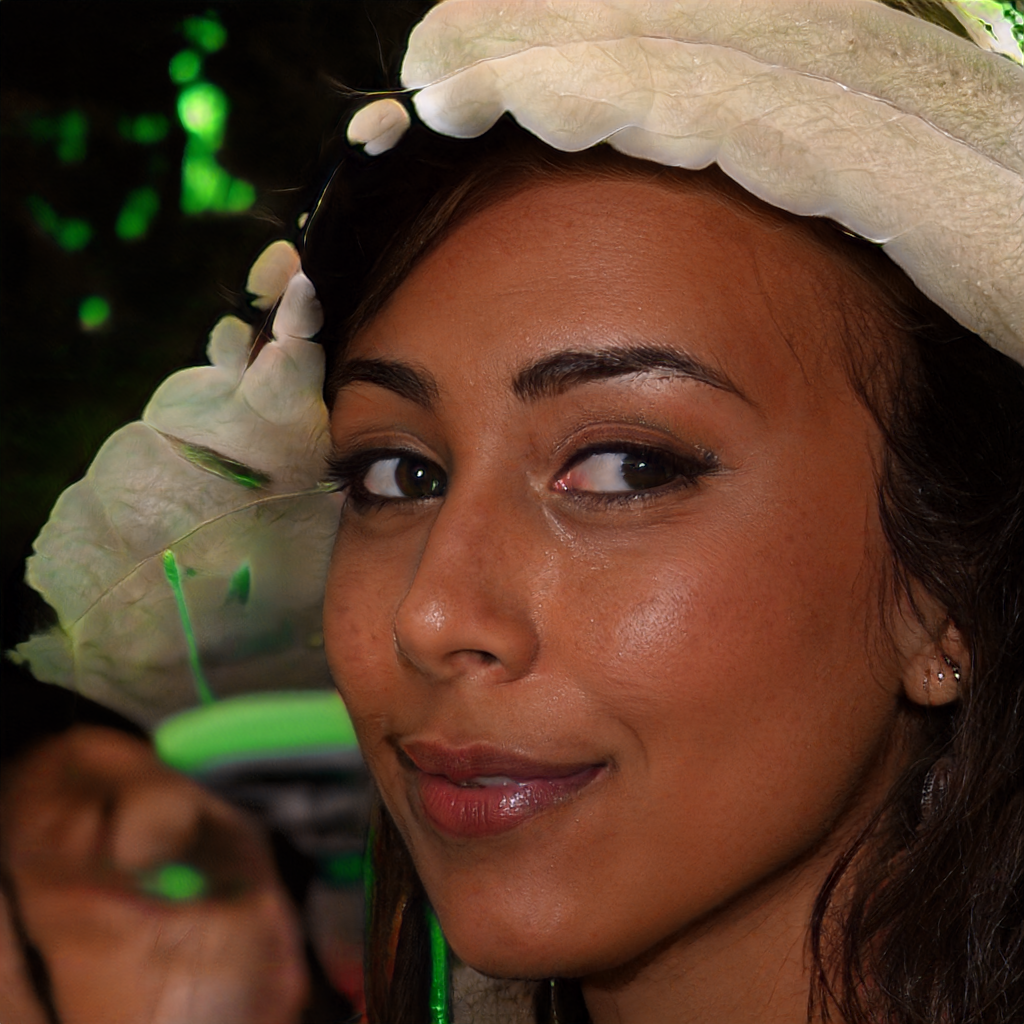

In [7]:
w = input_generator[0]()
c = input_generator[1]()

stylegan_invert_img_convert(
    generator(w, c, **generator_kwargs)
)

## Create PGT

The PGT (or Pseudo Ground Truth) is the real image to edit modified using tradionnal computer vision methods (such as histogram matching or poison blending).

In [8]:
img_path = "./Exemples/164462.jpg"
target_path = "./Exemples/00991.png"

# Creates the PGT for lips
pgt_lips = transfer_color(img_path, target_path, "Lips")
cv2.imwrite(r"./Exemples/pgt_lips.png", pgt_lips)

# Creates the PGT for hair
pgt_hair = transfer_color(img_path, target_path, "Hair")
cv2.imwrite(r"./Exemples/pgt_hair.png", pgt_hair)

# Creates the PGT for lion wrinkle
pgt_wrinkle = wrinkle_remover(img_path, "LionWrinkle")
cv2.imwrite(r"./Exemples/pgt_wrinkle.png", pgt_hair)

True

## Run the PTE algorithm

The PTE run in 3 steps + 1 optional

In [9]:
pte_dir = PivotalTuningEdition(
    generator=generator, target=img_path, 
    generator_kwargs=generator_kwargs, space_modifier=space_modifier
)

pte_dir.synthethise_with_directions(
    pseudo_target=r"./Exemples/pgt_lips.png",
    direction=None, invertion_iteration=1000, tuning_iteration=1000,
    initial_latent_function=initial_latent,
    gradient_optimizer=torch.optim.Adam,
    tune_optimizer=torch.optim.Adam, direction_type="Double_Invertion"
)

100%|██████████| 1000/1000 [07:12<00:00,  2.31it/s]


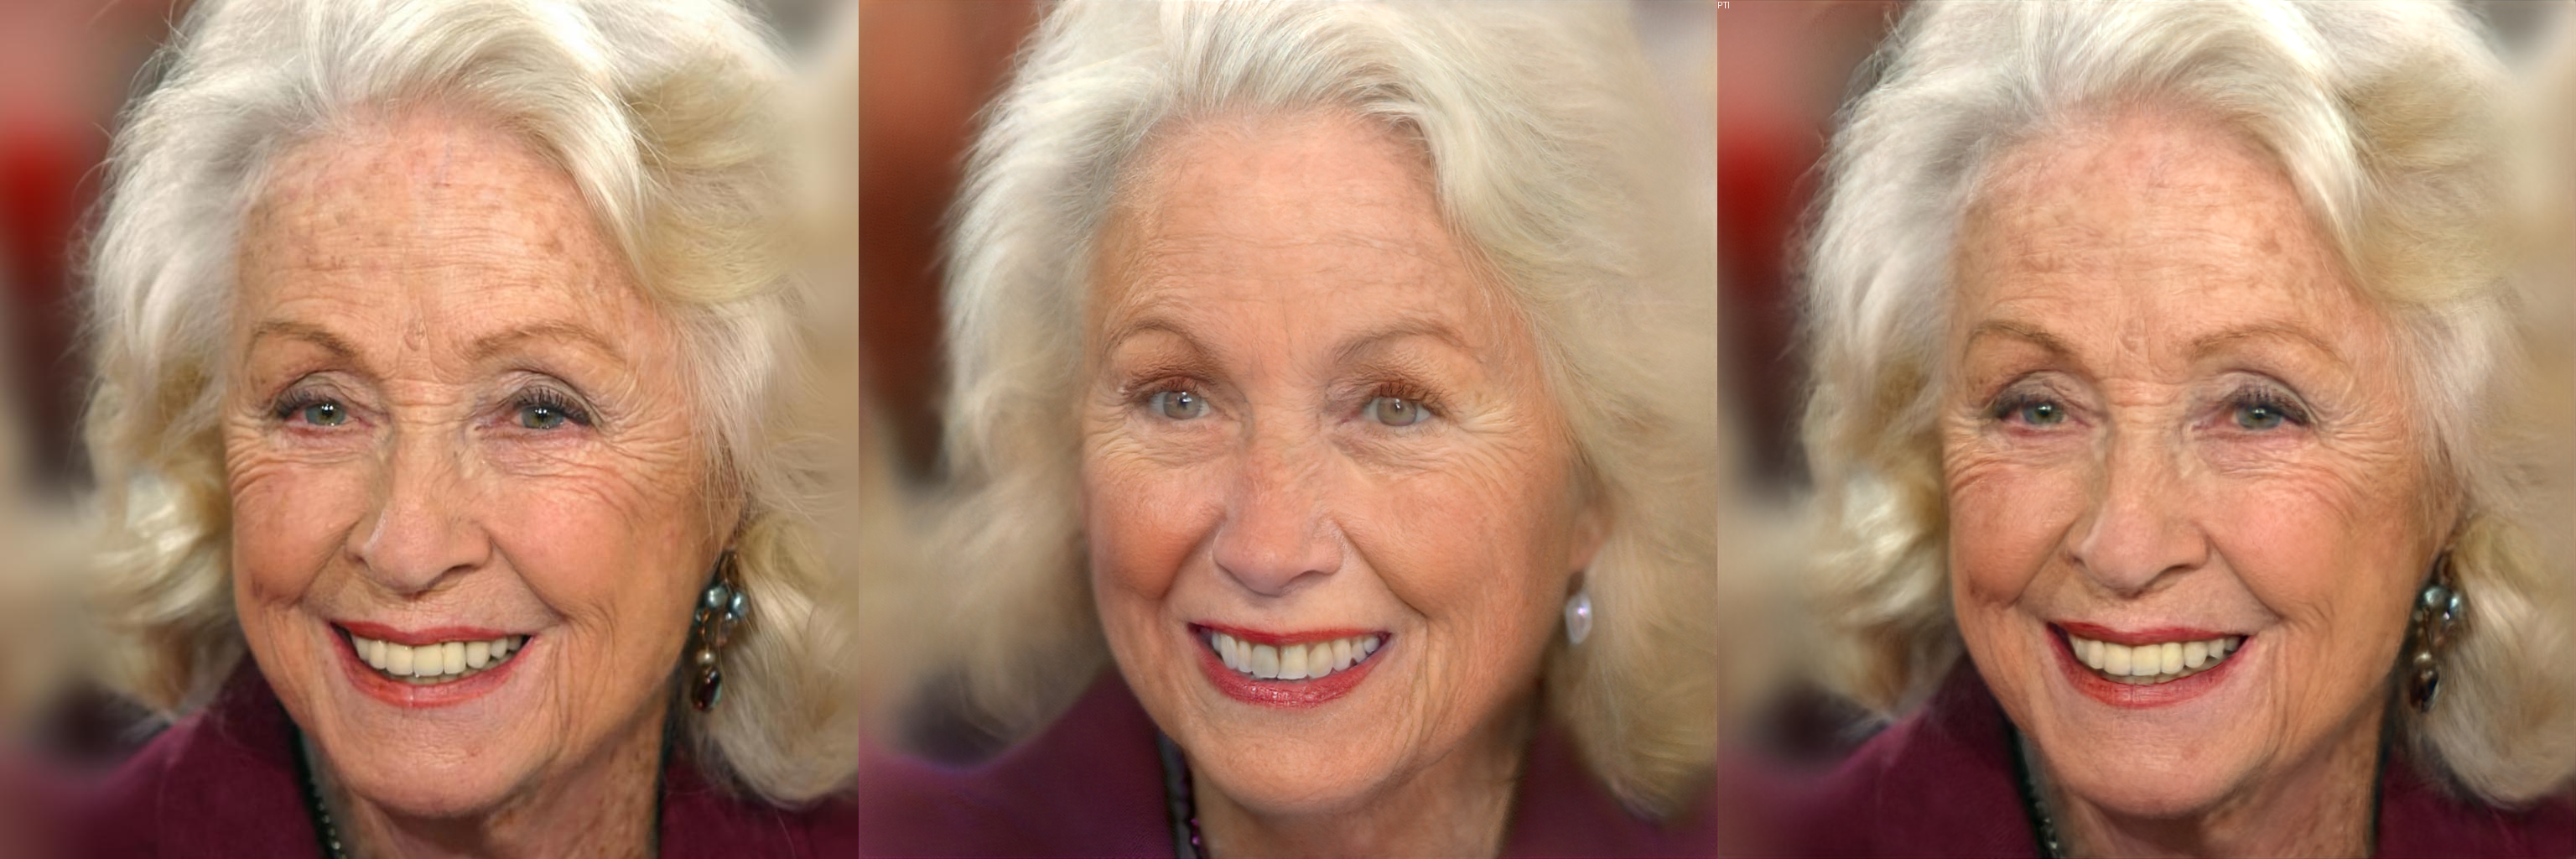

In [10]:
pte_dir.show_result()

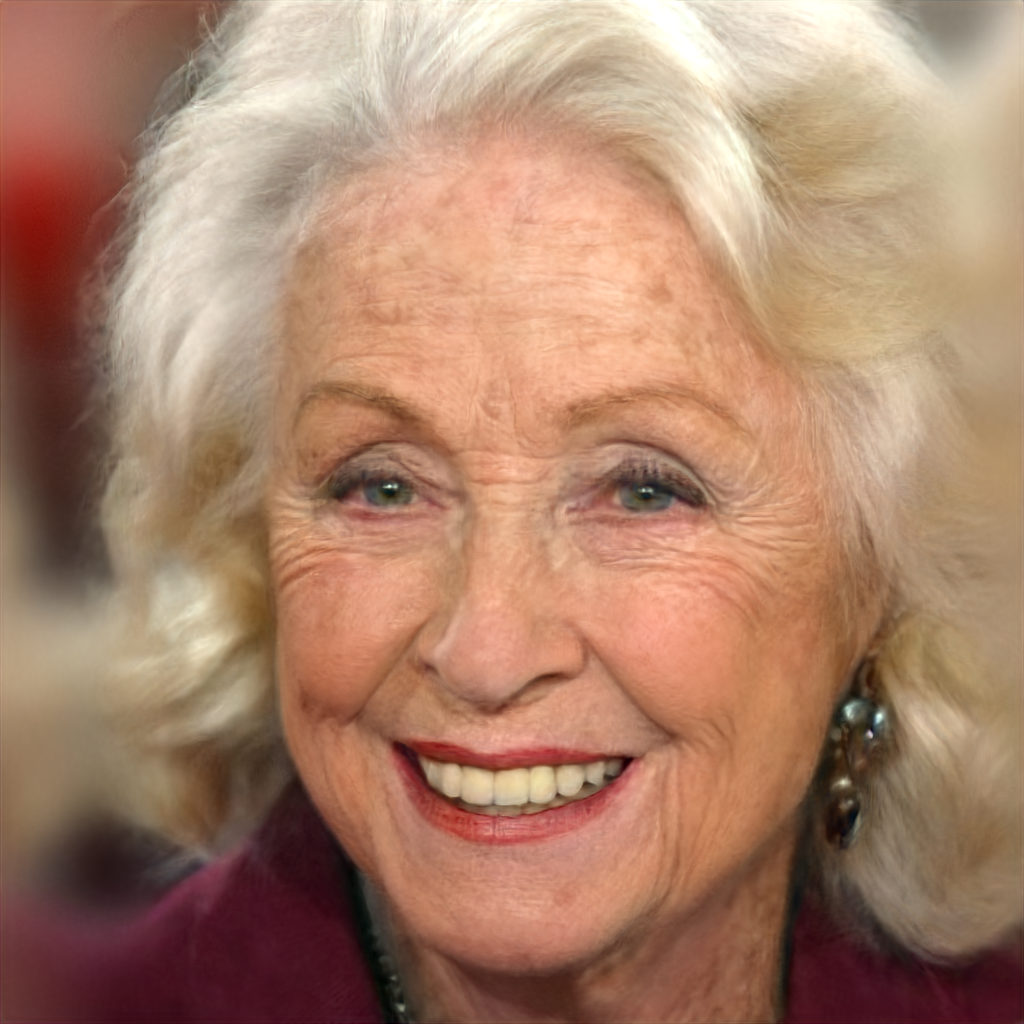

In [14]:
# You can modify the value of alpha to edit
pte_dir.edit_pivot(alpha=0)

In [15]:
# Save the trained model to be able to edit with an interface (check app.py for this)
pte_dir.save("./pte.pkl")